# Titanic: penalised logistic regression (elastic net) with h2o

Contents
 - Start
 - Import data
 - logistic regression with h2o
 
Notes
 - **h2o does not need onehot for hccv's**
 - This booklet is useful reference.  http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GLMBooklet.pdf
 - From within Python you can see some quite detailed examples and all the parameters if you type:
    - help(H2OGeneralizedLinearEstimator)
    - help(H2OGridSearch)     


Sources:
 - 

Copyright (C) 2018 Alan Chalk  
Please do not distribute or publish without permission.

## Start_.

**packages**

In [1]:
import os
import numpy as np
import pandas as pd

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

**Directories and paths**

In [2]:
# Set directories
print(os.getcwd())
dirRawData = "../input/"
dirPData =   "../PData/"

/home/jovyan/Projects/Titanic/PCode


**Functions**

In [3]:
def fn_accuracy(actuals, predictions):
    return np.mean(actuals == predictions)

**Load data**

In [4]:
df_train = pd.read_csv('../input/train.csv')
df_test  = pd.read_csv('../input/test.csv')

**Deal with missings**

Since the booklet (see comments below, says they will be excluded from training otherwise)

In [5]:
df_train.index[df_train['Age'].isna().values]

Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)

In [6]:
df_train['age_m'] = 0
df_test['age_m']  = 0
mean_miss = np.mean(df_train['Age'])

idx_miss = df_train.index[df_train['Age'].isna().values]
df_train.loc[idx_miss, 'age_m'] = 1
df_train.loc[idx_miss, 'Age'] = mean_miss
del idx_miss

idx_miss = df_test.index[df_test['Age'].isna().values]
df_test.loc[idx_miss, 'age_m'] = 1
df_test.loc[idx_miss, 'Age'] = mean_miss
del idx_miss, mean_miss


In [7]:
df_train['fare_m'] = 0
df_test['fare_m']  = 0
mean_miss = np.mean(df_train['Fare'])

idx_miss = df_train.index[df_train['Fare'].isna().values]
df_train.loc[idx_miss, 'fare_m'] = 1
df_train.loc[idx_miss, 'Fare'] = mean_miss
del idx_miss

idx_miss = df_test.index[df_test['Fare'].isna().values]
df_test.loc[idx_miss, 'fare_m'] = 1
df_test.loc[idx_miss, 'Fare'] = mean_miss
del idx_miss, mean_miss


In [8]:
df_train.isna().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
age_m            0
fare_m           0
dtype: int64

In [9]:
df_test.isna().sum(axis=0)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
age_m            0
fare_m           0
dtype: int64

**Define variables we will use**

In [10]:
var_dep = ['Survived']
vars_ind_numeric = ['Age', 'Fare']
vars_ind_cat = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'age_m', 'fare_m']
vars_ind = vars_ind_cat + vars_ind_numeric

# for convenience store dependent variable as y
y_train = df_train[var_dep].values.ravel()

### Penalised logistic regression 


Some comments about generalised linear models (of which logistic regression is one example) in H2O:
 - Read as much of the booklet if as you have time for.  But probably skip the section on GLM Model Families (pages 15 to 38).  And unless you like that sort of stuff, probably skip the section on Solver Selection (pages 43-44).
 - From the booklet: 
  - *We strongly recommend avoiding one-hot encoding categorical columns withmany  levels  into  many  binary  columns,  as  this  is  very  inefficient.   This  is especially true for Python users who are used to expanding their categoricalvariables manually for other frameworks.*
 - From the booklet. 
  - *The recommended way to find optimal regularization settings on H2O is to do a grid search over a few $\alpha$ values with an automatic lambda search for each $\alpha$.*  
  - This is exactly what we do below.
 - To enable k-fold cross validation, simple set nfolds>1. This is quite different from some of the sklearn packages where you typically need to use a different class.
 - Note the comment in the booklet in the section: Grid Search Over Alpha.  In our code here we search over many values just to demonstrate early stopping (which for some reason does not seem to work).
 - What about missing values? The booklet says:
  - What if the training data contains NA values? The rows with missing response are ignored during model training andvalidation.
  - What if the testing data contains NA values? If the missing value handling is set to skip and you are generating predictions, skipped rows will have NA (missing) prediction.
  - This is a bit if a puzzle because the booklet also says later on, regarding the parameter "missing_values_handling": Handling  of  missing  values.    Either Skip or MeanImputation (default).  When I manually mean imputed values here, my results were very similar to not imputing them - so I think missing_values_handling by default mean imputes missing even in the train data.
  - Note: I think we have seen that missing objects (strings) are OK...
 

**start h2o**

In [11]:
h2o.init(port=54321)
#h2o.connect()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-8u212-b03-0ubuntu1.18.04.1-b03); OpenJDK 64-Bit Server VM (build 25.212-b03, mixed mode)
  Starting server from /opt/conda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9boip6tg
  JVM stdout: /tmp/tmp9boip6tg/h2o_jovyan_started_from_python.out
  JVM stderr: /tmp/tmp9boip6tg/h2o_jovyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,"1 year, 2 months and 6 days !!!"
H2O cluster name:,H2O_from_python_jovyan_9tbumu
H2O cluster total nodes:,1
H2O cluster free memory:,891 Mb
H2O cluster total cores:,1
H2O cluster allowed cores:,1
H2O cluster status:,"accepting new members, healthy"


**Load data into h2o**

In [12]:
h2o_df_train = h2o.H2OFrame(df_train[vars_ind + var_dep], destination_frame = 'df_train') 
h2o_df_test  = h2o.H2OFrame(df_test[vars_ind], destination_frame = 'df_test') 

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
#help(h2o.estimators.glm.H2OGeneralizedLinearEstimator)
#help(H2OGridSearch)

In [14]:
# Set up the hyper parameters to search over
# We will (stupidly) search over 100 values for alpha - just so we can demonstrate random 
# search with early stopping

#alpha_opts = [0.0, 0.25, 0.5, 0.75, 0.99]

alpha_opts = np.arange(0, 1, 0.01).tolist()

hyper_parameters = {"alpha":alpha_opts}

In [15]:
# I've included the criteria dictionary from the help file, just 
# to demonstrate it
criteria = {# The default strategy, "Cartesian", covers the entire space of h-p combinations. 
            "strategy": "RandomDiscrete", 
            "max_runtime_secs": 600,
            "max_models": 30,
            "stopping_metric": "AUTO",
            "seed": 2020}

grid = H2OGridSearch(H2OGeneralizedLinearEstimator(family="binomial",
                                                   nfolds = 20,
                                                   lambda_search=True),
                     hyper_params=hyper_parameters,
                     grid_id='g1',
                     search_criteria=criteria)

grid.train(y = "Survived",
           x = vars_ind, 
           training_frame = h2o_df_train
           )



glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [16]:
# How many models are in the grid - should be as defined in grid search params
# I have NO IDEA why there are more!  If you do, please post on moodle!
grid = grid.get_grid(sort_by='accuracy', decreasing=True)
grid

                      alpha    model_ids            accuracy
0                    [0.29]  g1_model_28  0.8148148148148149
1                    [0.36]  g1_model_12   0.813692480359147
2                    [0.22]  g1_model_20  0.8125701459034792
3                    [0.73]  g1_model_10  0.8125701459034792
4                    [0.58]  g1_model_18  0.7991021324354658
5                    [0.31]  g1_model_30  0.7946127946127945
6                    [0.16]   g1_model_6  0.7878787878787878
7                    [0.18]  g1_model_26  0.7867564534231201
8                    [0.27]  g1_model_29  0.7867564534231201
9                    [0.12]   g1_model_5  0.7845117845117845
10                   [0.05]  g1_model_11  0.7845117845117845
11                   [0.84]  g1_model_15  0.7833894500561167
12    [0.35000000000000003]  g1_model_21  0.7822671156004489
13     [0.5700000000000001]   g1_model_8  0.7822671156004489
14                    [0.0]  g1_model_16  0.7811447811447811
15                   [0.

**Extract the best model from the grid**

In [17]:
bst = grid.models[0]

**Print the model**

In [18]:
print(bst)

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  g1_model_28


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.13924654352250787
RMSE: 0.3731575317778108
LogLoss: 0.4401070376731717
Null degrees of freedom: 890
Residual degrees of freedom: 880
Null deviance: 1186.6551368246774
Residual deviance: 784.270741133592
AIC: 806.270741133592
AUC: 0.8581019184269112
pr_auc: 0.8239562993949332
Gini: 0.7162038368538224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.351969291622021: 


,0,1,Error,Rate
0,432.0,117.0,0.2131,(117.0/549.0)
1,68.0,274.0,0.1988,(68.0/342.0)
Total,500.0,391.0,0.2076,(185.0/891.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3519693,0.7476126,229.0
max f2,0.1451578,0.7985574,318.0
max f0point5,0.6177104,0.8034380,140.0
max accuracy,0.5681341,0.8204265,159.0
max precision,0.9744825,1.0,0.0
max recall,0.0625173,1.0,381.0
max specificity,0.9744825,1.0,0.0
max absolute_mcc,0.6177104,0.6141915,140.0
max min_per_class_accuracy,0.3581662,0.7894737,226.0
max mean_per_class_accuracy,0.3519693,0.7940274,229.0


Gains/Lift Table: Avg response rate: 38.38 %, avg score: 38.38 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101010,0.9576187,2.3157895,2.3157895,0.8888889,0.9635225,0.8888889,0.9635225,0.0233918,0.0233918,131.5789474,131.5789474
,2,0.0202020,0.9489849,2.6052632,2.4605263,1.0,0.9536262,0.9444444,0.9585743,0.0263158,0.0497076,160.5263158,146.0526316
,3,0.0303030,0.9442479,2.6052632,2.5087719,1.0,0.9464679,0.9629630,0.9545388,0.0263158,0.0760234,160.5263158,150.8771930
,4,0.0404040,0.9355471,2.6052632,2.5328947,1.0,0.9392302,0.9722222,0.9507117,0.0263158,0.1023392,160.5263158,153.2894737
,5,0.0505051,0.9242421,2.6052632,2.5473684,1.0,0.9302744,0.9777778,0.9466242,0.0263158,0.1286550,160.5263158,154.7368421
,6,0.1010101,0.8661479,2.4894737,2.5184211,0.9555556,0.8950018,0.9666667,0.9208130,0.1257310,0.2543860,148.9473684,151.8421053
,7,0.1503928,0.7875765,2.5460526,2.5274941,0.9772727,0.8284970,0.9701493,0.8905003,0.1257310,0.3801170,154.6052632,152.7494108
,8,0.2008979,0.7253275,2.0263158,2.4014996,0.7777778,0.7601401,0.9217877,0.8577282,0.1023392,0.4824561,102.6315789,140.1499559
,9,0.3007856,0.5849532,1.6685393,2.1580911,0.6404494,0.6461982,0.8283582,0.7874813,0.1666667,0.6491228,66.8539326,115.8091123
,10,0.4017957,0.4160599,1.0421053,1.8775360,0.4,0.4991815,0.7206704,0.7150037,0.1052632,0.7543860,4.2105263,87.7536019




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.14339340936042502
RMSE: 0.37867322239686424
LogLoss: 0.4512327401195468
Null degrees of freedom: 890
Residual degrees of freedom: 880
Null deviance: 1188.5380025173836
Residual deviance: 804.0967428930323
AIC: 826.0967428930323
AUC: 0.8487388020750114
pr_auc: 0.8110099622800865
Gini: 0.6974776041500228
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5598416888138862: 


,0,1,Error,Rate
0,494.0,55.0,0.1002,(55.0/549.0)
1,110.0,232.0,0.3216,(110.0/342.0)
Total,604.0,287.0,0.1852,(165.0/891.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5598417,0.7376789,155.0
max f2,0.1479958,0.7945135,310.0
max f0point5,0.5964728,0.7863188,142.0
max accuracy,0.5964728,0.8148148,142.0
max precision,0.9280216,0.9772727,20.0
max recall,0.0623785,1.0,380.0
max specificity,0.9689140,0.9981785,0.0
max absolute_mcc,0.5964728,0.6019681,142.0
max min_per_class_accuracy,0.3575581,0.7777778,221.0
max mean_per_class_accuracy,0.5598417,0.7890902,155.0


Gains/Lift Table: Avg response rate: 38.38 %, avg score: 38.45 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101010,0.9580857,2.3157895,2.3157895,0.8888889,0.9628894,0.8888889,0.9628894,0.0233918,0.0233918,131.5789474,131.5789474
,2,0.0202020,0.9506234,2.6052632,2.4605263,1.0,0.9539471,0.9444444,0.9584182,0.0263158,0.0497076,160.5263158,146.0526316
,3,0.0303030,0.9418633,2.6052632,2.5087719,1.0,0.9464789,0.9629630,0.9544384,0.0263158,0.0760234,160.5263158,150.8771930
,4,0.0404040,0.9341469,2.6052632,2.5328947,1.0,0.9383431,0.9722222,0.9504146,0.0263158,0.1023392,160.5263158,153.2894737
,5,0.0505051,0.9243787,2.3157895,2.4894737,0.8888889,0.9296433,0.9555556,0.9462603,0.0233918,0.1257310,131.5789474,148.9473684
,6,0.1010101,0.8665491,2.5473684,2.5184211,0.9777778,0.8948537,0.9666667,0.9205570,0.1286550,0.2543860,154.7368421,151.8421053
,7,0.1503928,0.7870585,2.4276316,2.4886096,0.9318182,0.8268695,0.9552239,0.8897940,0.1198830,0.3742690,142.7631579,148.8609584
,8,0.2008979,0.7173924,1.9684211,2.3578359,0.7555556,0.7608305,0.9050279,0.8573730,0.0994152,0.4736842,96.8421053,135.7835931
,9,0.3007856,0.5964234,1.7563572,2.1580911,0.6741573,0.6482714,0.8283582,0.7879325,0.1754386,0.6491228,75.6357185,115.8091123
,10,0.4006734,0.4115753,0.9367238,1.8536046,0.3595506,0.5037413,0.7114846,0.7170837,0.0935673,0.7426901,-6.3276168,85.3604600



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid,cv_11_valid,cv_12_valid,cv_13_valid,cv_14_valid,cv_15_valid,cv_16_valid,cv_17_valid,cv_18_valid,cv_19_valid,cv_20_valid
accuracy,0.8351695,0.0434734,0.8235294,0.8076923,0.7555556,0.7608696,0.8,0.7179487,0.9444444,0.902439,0.7727272,0.9111111,0.8461539,0.7884616,0.8297872,0.8461539,0.7826087,0.8478261,0.8478261,0.8936170,0.8913044,0.9333333
auc,0.8456320,0.0431665,0.8285714,0.8851675,0.7874494,0.8570076,0.75,0.8280423,0.9581530,0.8818182,0.7933884,0.8739496,0.8463902,0.8341308,0.8481482,0.7056451,0.80625,0.8296146,0.9083821,0.8511905,0.8661258,0.9732143
err,0.1648305,0.0434734,0.1764706,0.1923077,0.2444444,0.2391304,0.2,0.2820513,0.0555556,0.0975610,0.2272727,0.0888889,0.1538462,0.2115385,0.1702128,0.1538462,0.2173913,0.1521739,0.1521739,0.1063830,0.1086957,0.0666667
err_count,7.35,2.0034347,6.0,10.0,11.0,11.0,8.0,11.0,3.0,4.0,10.0,4.0,8.0,11.0,8.0,6.0,10.0,7.0,7.0,5.0,5.0,2.0
f0point5,0.7852688,0.0620630,0.7692308,0.7142857,0.7009346,0.7142857,0.7638889,0.6716418,0.8974359,0.8510638,0.7627119,0.942029,0.8247423,0.7009346,0.8152174,0.625,0.6818182,0.8219178,0.7943925,0.8333333,0.9230769,0.8974359
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
r2,0.3826166,0.0896052,0.3345959,0.4462042,0.3085620,0.3702689,0.2289873,0.2428366,0.5724444,0.434025,0.2710866,0.5052289,0.4177876,0.3324979,0.3779057,0.1074321,0.2657411,0.3670202,0.4488615,0.4404869,0.5108556,0.6695035
recall,0.803178,0.0912006,0.8571429,0.8947368,0.7894737,1.0,0.6875,1.0,1.0,0.7272728,0.8181818,0.7647059,0.7619048,0.7894737,0.75,0.5,0.75,0.7058824,0.8947368,0.6666667,0.7058824,1.0
residual_deviance,39.761208,5.3400207,34.07286,41.485016,47.299812,43.416603,44.748272,42.96615,36.162697,29.799288,49.231136,35.582245,46.442528,49.505062,45.397144,36.153057,45.91638,42.603706,37.61356,33.7803,35.453953,17.594355
rmse,0.3749187,0.0280139,0.4014605,0.3583482,0.4107027,0.3964028,0.4301663,0.4337865,0.3187639,0.3333279,0.4268821,0.3410304,0.3743931,0.3934203,0.3899663,0.3814889,0.4081195,0.3840259,0.3655369,0.3261609,0.3375858,0.2868046



See the whole table with table.as_data_frame()
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2020-07-13 13:00:31,0.000 sec,1,.57E0,1,1.3318239,nan,1.3349657,0.0153653
,2020-07-13 13:00:31,0.001 sec,3,.52E0,2,1.3239910,nan,1.3320964,0.0153047
,2020-07-13 13:00:31,0.003 sec,5,.47E0,2,1.3163008,nan,1.3246696,0.0153058
,2020-07-13 13:00:31,0.005 sec,7,.43E0,4,1.3079938,nan,1.3172391,0.0153585
,2020-07-13 13:00:31,0.006 sec,9,.39E0,4,1.2874538,nan,1.3037951,0.0154369
---,---,---,---,---,---,---,---,---,---
,2020-07-13 13:00:31,0.081 sec,93,.41E-2,10,0.8804696,nan,0.9044317,0.0355895
,2020-07-13 13:00:31,0.083 sec,94,.37E-2,11,0.8802141,nan,0.9044285,0.0358043
,2020-07-13 13:00:31,0.084 sec,95,.34E-2,11,0.8799959,nan,0.9044487,0.0360046
,2020-07-13 13:00:31,0.085 sec,96,.31E-2,11,0.8798108,nan,0.9044898,0.0361907



See the whole table with table.as_data_frame()



**View performance metrics**

In [19]:
print("MSE", bst.mse(train=True, valid=True))
print("logloss", bst.logloss(train=True, valid=True))
print("Accuracy", bst.accuracy(train=True, valid=True))

MSE {'train': 0.13924654352250787, 'valid': None}
logloss {'train': 0.4401070376731717, 'valid': None}
Accuracy {'train': [[0.5681340602318017, 0.8204264870931538]], 'valid': None}


**Is performance consistent over the various folds?**

In [20]:
for model_ in bst.get_xval_models():
    print (model_.model_id, " training auc:",model_.auc(), " validation auc: ", model_.auc(valid=True))

g1_model_28_cv_1  training auc: 0.8598425469131818  validation auc:  0.8285714285714286
g1_model_28_cv_2  training auc: 0.8570511435908512  validation auc:  0.8851674641148325
g1_model_28_cv_3  training auc: 0.8610333335306548  validation auc:  0.7874493927125505
g1_model_28_cv_4  training auc: 0.8575416666666668  validation auc:  0.8570075757575757
g1_model_28_cv_5  training auc: 0.8597808939526731  validation auc:  0.75
g1_model_28_cv_6  training auc: 0.8601933688739244  validation auc:  0.828042328042328
g1_model_28_cv_7  training auc: 0.8518800260812867  validation auc:  0.9581529581529582
g1_model_28_cv_8  training auc: 0.8570804882734051  validation auc:  0.8818181818181817
g1_model_28_cv_9  training auc: 0.8591051944971537  validation auc:  0.793388429752066
g1_model_28_cv_10  training auc: 0.8575697622914514  validation auc:  0.8739495798319327
g1_model_28_cv_11  training auc: 0.8593560182345229  validation auc:  0.8463901689708141
g1_model_28_cv_12  training auc: 0.85919912640

**What are the coefficients?**

In [21]:
# Normalised coefficients
bst_coef = bst.coef_norm()
bst_coef

{'Intercept': 0.030754517118264824,
 'Embarked.C': 0.0,
 'Embarked.Q': 0.004811886641967384,
 'Embarked.S': -0.40757358583184583,
 'Embarked.nan': 0.0,
 'Sex.female': 1.2801001815215087,
 'Sex.male': -1.2658869323045447,
 'Pclass': -0.8485466848031566,
 'SibSp': -0.32337928758898565,
 'Parch': -0.06880445938515553,
 'age_m': -0.09917867303863424,
 'Age': -0.46764608281557757,
 'Fare': 0.0992449548569269}

In [22]:
# Coefficients for original variables
bst_coef = bst.coef()
bst_coef

{'Intercept': 3.613019893515755,
 'Embarked.C': 0.0,
 'Embarked.Q': 0.004811886641967384,
 'Embarked.S': -0.40757358583184583,
 'Embarked.nan': 0.0,
 'Sex.female': 1.2801001815215087,
 'Sex.male': -1.2658869323045447,
 'Pclass': -1.0149215081379053,
 'SibSp': -0.2932497969327619,
 'Parch': -0.08535927423205009,
 'age_m': -0.24843707627542505,
 'Age': -0.03596720005990505,
 'Fare': 0.0019971444446189226}

**Calculate one prediction by hand**

Let's try to calculate the prediction for the first train example

In [23]:
df_train.iloc[0]

PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                                 22
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
age_m                                0
fare_m                               0
Name: 0, dtype: object

We have
 - 'Embarked = "S"
 - 'Sex' = 'male'
 - 'Pclass': 3
 - 'SibSp': 1
 - 'Parch': 0
 - 'Age': 22
 - 'Fare': 7.25 

So our linear predictor is (something like - depending on what models you are running...):
 - +3.6977083826221824  (intercept)
 - -0.36966806191950596 ('Embarked = "S")
 - -1.2936519932945865 ('Sex' = 'male')
 - -1.0668360883558596 * 3 (Pclass = 3: did it make ANY sense to fit this as a numeric feature???)
 - -0.3054373949219665 * 1 ('SibSp' = 1)
 - -0.07687389625171188 * 0 ('Parch' = 0)
 - -0.0375122337702396 * 22 (Age 22)
 - +0.0019047574242136308 * 7.25 (Fare 7.25)

In [25]:
lpred_example1 = +bst_coef['Intercept'] + \
                 bst_coef['Embarked.S'] + \
                 bst_coef['Sex.male'] + \
                 bst_coef['Pclass'] * 3 + \
                 bst_coef['SibSp'] * 1 + \
                 bst_coef['Parch'] * 0 + \
                 bst_coef['Age'] * 22 + \
                 bst_coef['Fare'] * 7.25



In [26]:
pred_example1 = np.exp(lpred_example1) / (1 + np.exp(lpred_example1))
pred_example1

0.10199479791877711

Now find all predictions using the .predict method of the model class

In [27]:
df_bst_preds_train = bst.predict(h2o_df_train).as_data_frame()
df_bst_preds_test = bst.predict(h2o_df_test).as_data_frame()
df_bst_preds_train.head(5)


glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


,predict,p0,p1
0,0,0.898005,0.101995
1,1,0.086230,0.913770
2,1,0.372510,0.627490
3,1,0.116647,0.883353
4,0,0.912774,0.087226


Did we get the first prediction right?

In [28]:
np.round(df_bst_preds_train.iloc[0]['p1'], 5) == np.round(pred_example1, 5)

True

**Histogram of predictions**

Do they lie between zero and one??

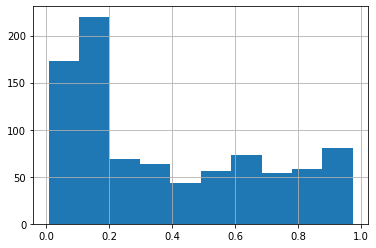

In [30]:
df_bst_preds_train['p1'].hist()

**What was the linear predictor before the logistic transform?**

I cannot see any parameter to pass to .predict in order to return the linear predictor, so we will calclate ourselves..

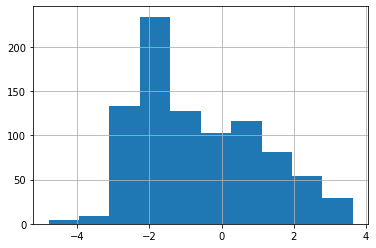

In [31]:
p = df_bst_preds_train['p1'].values
eta = np.log(p / (1 - p))
df_bst_preds_train['eta'] = eta
df_bst_preds_train['eta'].hist()

Fix a threshold based on train

In [32]:
from scipy.optimize import minimize_scalar

In [35]:
def fn_accuracy_th(x):
    return -fn_accuracy(df_bst_preds_train['p1'].values > x, y_train)

res = minimize_scalar(fn_accuracy_th, method='Bounded', bounds = [0, 1])
res

     fun: -0.819304152637486
 message: 'Solution found.'
    nfev: 21
  status: 0
 success: True
       x: 0.6105957329009364

In [36]:
th = res['x']
th

0.6105957329009364

**Create submission for Kaggle**

One thing I tried was, rather than finding ourselves the threshold that maximises accuracy, we will use the threshold that h2o uses - which is chosen to maximise the F1 score (https://en.wikipedia.org/wiki/F1_score) on the training data.  However this gave a remarkably poor result.  So back to finding the threshold ourselves...

In [37]:
df_sub_2 = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": 1 * (df_bst_preds_test['p1'].values > th)
    })

In [38]:
df_sub_2.to_csv('../POutput/06a_pd_sub_2.csv', index=False)

In [39]:
h2o.cluster().shutdown()

H2O session _sid_a1ca closed.


In [ ]:
# Depending on which model I ran and how I chose the th, I tend to get Kaggle results between 0.74 and 0.77 on test